DATA CLEANING & PREPROCESSING PIPELINE
Raw Dataset: 525,461 rows × 8 columns

EXECUTING CLEANING PIPELINE
----------------------------------------
Step completed: Remove Duplicates: 518,596 rows remaining
Step completed: Handle Missing Values: 410,763 rows remaining
Step completed: Clean Transactions: 400,891 rows remaining
Step completed: Create Derived Features: 400,891 rows remaining

DATA VALIDATION RESULTS:
----------------------------------------
No negative quantities: PASS
No negative prices: PASS
No missing customer IDs: PASS
Valid date range: PASS
Reasonable total amounts: PASS

DATA CLEANING SUMMARY
Original Shape: 525,461 rows × 8 columns
Final Shape: 400,891 rows × 17 columns
Rows Removed: 124,570 (23.7%)
Features Added: 9

Step-by-Step Summary:
                      Step    Rows  Columns  Removed_Rows  Added_Features
0        Remove Duplicates  518596        8          6865               0
1    Handle Missing Values  410763        8        107833               0
2       C

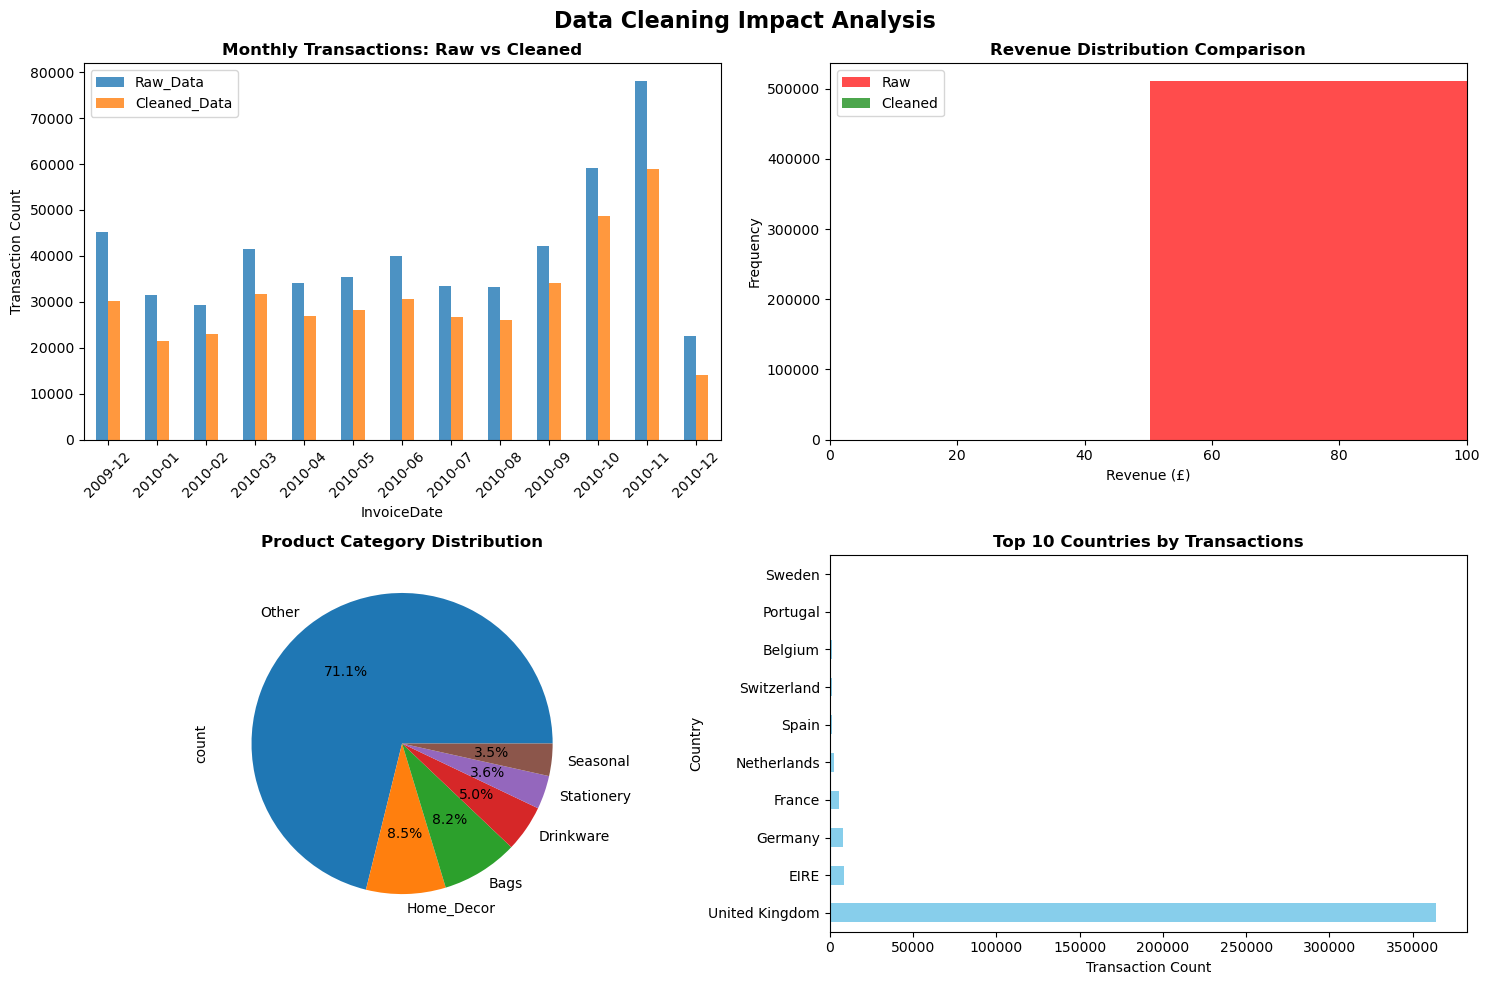


DATA CLEANING COMPLETE
Ready for customer segmentation and sales forecasting analysis!


In [2]:
"""
E-Commerce Sales Data Cleaning Pipeline
======================================
Author: Komal
Date: August 2025
Objective: Comprehensive data cleaning and preprocessing
"""

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("DATA CLEANING & PREPROCESSING PIPELINE")
print("="*60)

# Load raw data
df_raw = pd.read_csv('../data/raw/ecommerce_data.csv')
print(f"Raw Dataset: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")

# Create a copy for processing
df = df_raw.copy()

class ECommerceDataCleaner:
    """
    Professional data cleaning pipeline for e-commerce transaction data
    """
    
    def __init__(self, data):
        self.data = data.copy()
        self.cleaning_log = []
        self.original_shape = data.shape
        
    def log_step(self, step_name, removed_rows=0, added_features=0):
        """Log cleaning steps for transparency"""
        current_shape = self.data.shape
        self.cleaning_log.append({
            'Step': step_name,
            'Rows': current_shape[0],
            'Columns': current_shape[1],
            'Removed_Rows': removed_rows,
            'Added_Features': added_features
        })
        print(f"Step completed: {step_name}: {current_shape[0]:,} rows remaining")
    
    def remove_duplicates(self):
        """Remove exact duplicate transactions"""
        initial_rows = len(self.data)
        self.data = self.data.drop_duplicates()
        removed = initial_rows - len(self.data)
        self.log_step("Remove Duplicates", removed_rows=removed)
        return self
    
    def handle_missing_values(self):
        """Handle missing values strategically"""
        initial_rows = len(self.data)
        
        # Remove rows with missing CustomerID (can't analyze customer behavior)
        self.data = self.data.dropna(subset=['CustomerID'])
        
        # Remove rows with missing Description (can't identify product)
        self.data = self.data.dropna(subset=['Description'])
        
        removed = initial_rows - len(self.data)
        self.log_step("Handle Missing Values", removed_rows=removed)
        return self
    
    def clean_transactions(self):
        """Clean transaction-level data quality issues"""
        initial_rows = len(self.data)
        
        # Remove cancelled orders (negative quantities)
        self.data = self.data[self.data['Quantity'] > 0]
        
        # Remove unrealistic unit prices
        self.data = self.data[
            (self.data['UnitPrice'] > 0) & 
            (self.data['UnitPrice'] <= 1000)  # £1000 seems reasonable max
        ]
        
        # Remove test transactions or anomalies
        self.data = self.data[self.data['Quantity'] <= 10000]  # Reasonable quantity limit
        
        removed = initial_rows - len(self.data)
        self.log_step("Clean Transactions", removed_rows=removed)
        return self
    
    def create_derived_features(self):
        """Engineer new features for analysis"""
        initial_cols = self.data.shape[1]
        
        # Convert invoice date to datetime
        self.data['InvoiceDate'] = pd.to_datetime(self.data['InvoiceDate'])
        
        # Financial metrics
        self.data['TotalAmount'] = self.data['Quantity'] * self.data['UnitPrice']
        
        # Temporal features
        self.data['Year'] = self.data['InvoiceDate'].dt.year
        self.data['Month'] = self.data['InvoiceDate'].dt.month
        self.data['DayOfWeek'] = self.data['InvoiceDate'].dt.day_name()
        self.data['Hour'] = self.data['InvoiceDate'].dt.hour
        self.data['IsWeekend'] = self.data['InvoiceDate'].dt.weekday >= 5
        
        # Product categorization
        self.data['ProductCategory'] = self.data['Description'].apply(self._categorize_product)
        
        # Customer transaction metrics
        self.data['InvoiceValue'] = self.data.groupby('InvoiceNo')['TotalAmount'].transform('sum')
        self.data['ItemsInInvoice'] = self.data.groupby('InvoiceNo')['Quantity'].transform('sum')
        
        added_features = self.data.shape[1] - initial_cols
        self.log_step("Create Derived Features", added_features=added_features)
        return self
    
    def _categorize_product(self, description):
        """Categorize products based on description"""
        desc_lower = str(description).lower()
        
        if any(word in desc_lower for word in ['bag', 'handbag', 'tote']):
            return 'Bags'
        elif any(word in desc_lower for word in ['candle', 'light', 'lantern']):
            return 'Home_Decor'
        elif any(word in desc_lower for word in ['card', 'notebook', 'journal']):
            return 'Stationery'
        elif any(word in desc_lower for word in ['christmas', 'xmas', 'holiday']):
            return 'Seasonal'
        elif any(word in desc_lower for word in ['mug', 'cup', 'glass']):
            return 'Drinkware'
        else:
            return 'Other'
    
    def validate_data(self):
        """Final data validation checks"""
        validation_checks = {
            'No negative quantities': (self.data['Quantity'] > 0).all(),
            'No negative prices': (self.data['UnitPrice'] > 0).all(),
            'No missing customer IDs': self.data['CustomerID'].notna().all(),
            'Valid date range': self.data['InvoiceDate'].notna().all(),
            'Reasonable total amounts': (self.data['TotalAmount'] >= 0).all()
        }
        
        print("\nDATA VALIDATION RESULTS:")
        print("-" * 40)
        for check, passed in validation_checks.items():
            status = "PASS" if passed else "FAIL"
            print(f"{check}: {status}")
        
        return all(validation_checks.values())
    
    def get_cleaning_summary(self):
        """Generate comprehensive cleaning summary"""
        summary_df = pd.DataFrame(self.cleaning_log)
        
        print(f"\nDATA CLEANING SUMMARY")
        print("=" * 50)
        print(f"Original Shape: {self.original_shape[0]:,} rows × {self.original_shape[1]} columns")
        print(f"Final Shape: {self.data.shape[0]:,} rows × {self.data.shape[1]} columns")
        print(f"Rows Removed: {self.original_shape[0] - self.data.shape[0]:,} ({((self.original_shape[0] - self.data.shape[0])/self.original_shape[0]*100):.1f}%)")
        print(f"Features Added: {self.data.shape[1] - self.original_shape[1]}")
        print("\nStep-by-Step Summary:")
        print(summary_df)
        
        return summary_df

# Execute cleaning pipeline
print("\nEXECUTING CLEANING PIPELINE")
print("-" * 40)

cleaner = ECommerceDataCleaner(df)
cleaned_data = (cleaner
                .remove_duplicates()
                .handle_missing_values()
                .clean_transactions()
                .create_derived_features())

# Validation
is_valid = cleaner.validate_data()
cleaning_summary = cleaner.get_cleaning_summary()

# Get cleaned data
df_clean = cleaner.data

# Save cleaned data
df_clean.to_csv('../data/processed/cleaned_data.csv', index=False)
print(f"\nCleaned data saved to '../data/processed/cleaned_data.csv'")

# Generate data quality report
print(f"\nFINAL DATASET OVERVIEW")
print("=" * 50)
print(f"Date Range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")
print(f"Total Revenue: £{df_clean['TotalAmount'].sum():,.2f}")
print(f"Unique Customers: {df_clean['CustomerID'].nunique():,}")
print(f"Total Orders: {df_clean['InvoiceNo'].nunique():,}")
print(f"Unique Products: {df_clean['StockCode'].nunique():,}")
print(f"Countries: {df_clean['Country'].nunique()}")

# Visualization of cleaning impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly transaction count comparison
monthly_comparison = pd.DataFrame({
    'Raw_Data': df_raw.groupby(pd.to_datetime(df_raw['InvoiceDate']).dt.to_period('M')).size(),
    'Cleaned_Data': df_clean.groupby(df_clean['InvoiceDate'].dt.to_period('M')).size()
})

monthly_comparison.plot(kind='bar', ax=axes[0,0], alpha=0.8)
axes[0,0].set_title('Monthly Transactions: Raw vs Cleaned', fontweight='bold')
axes[0,0].set_ylabel('Transaction Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Revenue distribution
axes[0,1].hist([df_raw[df_raw['Quantity'] * df_raw['UnitPrice'] > 0]['Quantity'] * df_raw[df_raw['Quantity'] * df_raw['UnitPrice'] > 0]['UnitPrice'],
                df_clean['TotalAmount']], 
               bins=50, alpha=0.7, label=['Raw', 'Cleaned'], color=['red', 'green'])
axes[0,1].set_title('Revenue Distribution Comparison', fontweight='bold')
axes[0,1].set_xlabel('Revenue (£)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].set_xlim(0, 100)

# Product categories
df_clean['ProductCategory'].value_counts().plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%')
axes[1,0].set_title('Product Category Distribution', fontweight='bold')

# Top countries
df_clean['Country'].value_counts().head(10).plot(kind='barh', ax=axes[1,1], color='skyblue')
axes[1,1].set_title('Top 10 Countries by Transactions', fontweight='bold')
axes[1,1].set_xlabel('Transaction Count')

plt.suptitle('Data Cleaning Impact Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/cleaning_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDATA CLEANING COMPLETE")
print("=" * 60)
print(f"Ready for customer segmentation and sales forecasting analysis!")
